<a href="https://colab.research.google.com/github/saumya-699/Data-Analytics-Process-and-Interpretation/blob/main/Data_Analytics_Process_and_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/content/drive/MyDrive/BIS/diabetes.csv')


In [17]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [16]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [15]:
data.shape

(768, 9)

In [14]:
data.value_counts()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI   DiabetesPedigreeFunction  Age  Outcome
0            57       60             0              0        21.7  0.735                     67   0          1
             67       76             0              0        45.3  0.194                     46   0          1
5            103      108            37             0        39.2  0.305                     65   0          1
             104      74             0              0        28.8  0.153                     48   0          1
             105      72             29             325      36.9  0.159                     28   0          1
                                                                                                            ..
2            84       50             23             76       30.4  0.968                     21   0          1
             85       65             0              0        39.6  0.930                     27   0          1
             87       0              23             0        28.9  0.773                     25   0          1
                      58             16             52       32.7  0.166                     25   0          1
17           163      72             41             114      40.9  0.817                     47   1          1
Name: count, Length: 768, dtype: int64

In [13]:
data.dtypes

,0
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
Outcome,int64


In [12]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [18]:
data.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [19]:
data[data.duplicated]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [ ]:
# so there is no null values however the Insulin column has a lot of missing values in 0 value.

In [25]:
# Calculate the percentage of zero values for each column
zero_percentage = (data.eq(0).sum() / len(data)) * 100

# Print results
print("Percentage of zero values in each column:")
print(zero_percentage)


Percentage of zero values in each column:
Pregnancies                 14.453125
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                     65.104167
dtype: float64


In [26]:
cols_median = ['Glucose', 'BloodPressure', 'BMI']
data[cols_median] = data[cols_median].replace(0, np.nan).fillna(data[cols_median].median())


In [28]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)

cols_knn = ['SkinThickness', 'Insulin']
data[cols_knn] = knn_imputer.fit_transform(data[cols_knn])


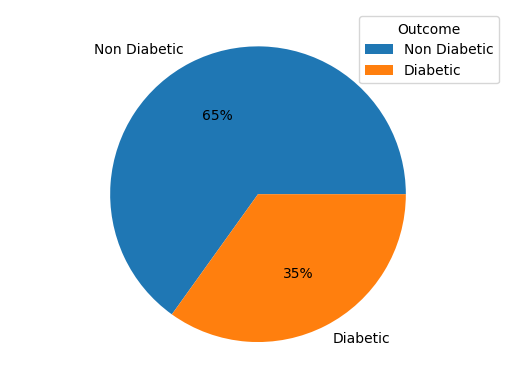

In [32]:
# Let's see the difference between the people who has diabetes or not
outcome_count = data["Outcome"].value_counts()
outcome_count
plt.axis("equal")
plt.pie(outcome_count, labels = ["Non Diabetic","Diabetic"],autopct='%0.0f%%')
plt.legend(title="Outcome")
plt.show()

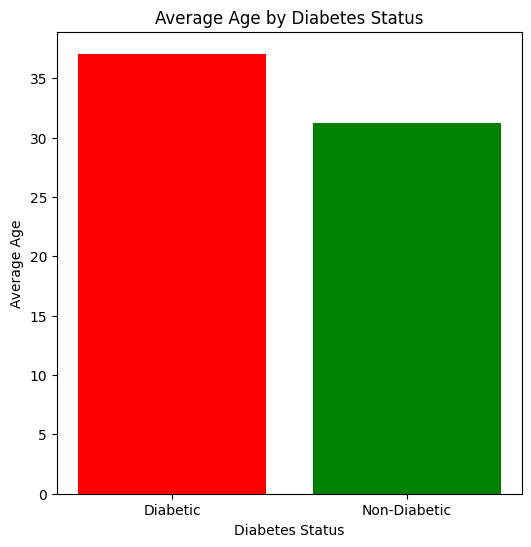

In [34]:
# This chart represent the differance in the mean age between Diabetic and non-Diabetic patients
diabetic_patients = df[df['Outcome']==1]
nondiabetic_patients = df[df['Outcome']==0]

avg_DP = diabetic_patients['Age'].mean()
avg_nonDP = nondiabetic_patients['Age'].mean()

plt.figure(figsize=(6, 6))
plt.bar(["Diabetic", "Non-Diabetic"], [avg_DP, avg_nonDP], color=['red', 'green'])
plt.xlabel("Diabetes Status")
plt.ylabel("Average Age")
plt.title("Average Age by Diabetes Status")
plt.show()

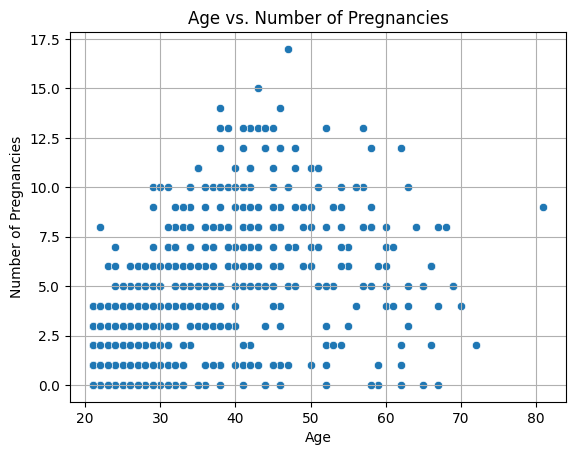

In [35]:
# This chart represent the correlation between age and number of pregnancies
sns.scatterplot(x="Age", y="Pregnancies", data=data)
plt.xlabel("Age")
plt.ylabel("Number of Pregnancies")
plt.title("Age vs. Number of Pregnancies")
plt.grid(True)
plt.show()

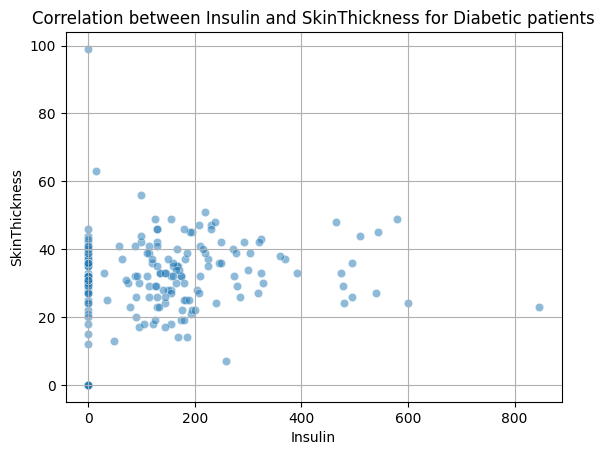

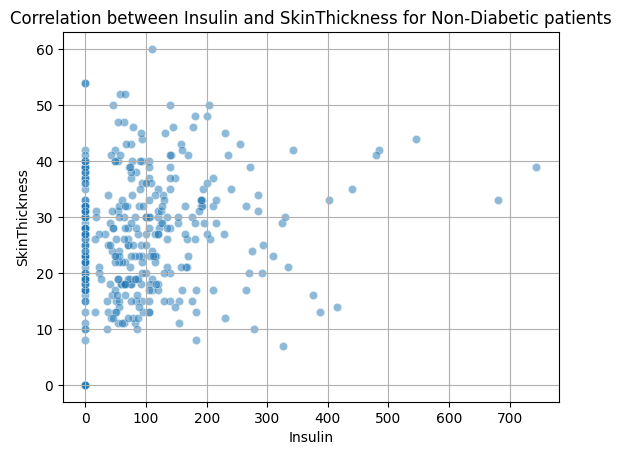

In [36]:
# Filter for diabetic and non-diabetic groups
diabetic = data[data["Outcome"] == 1]
non_diabetic = data[data["Outcome"] == 0]

# Scatterplot for diabetic patients
sns.scatterplot(x="Insulin", y="SkinThickness", data=diabetic, alpha=0.5)
plt.xlabel("Insulin")
plt.ylabel("SkinThickness")
plt.title("Correlation between Insulin and SkinThickness for Diabetic patients")
plt.grid(True)
plt.show()

# Scatterplot for non-diabetic patients
sns.scatterplot(x="Insulin", y="SkinThickness", data=non_diabetic, alpha=0.5)
plt.xlabel("Insulin")
plt.ylabel("SkinThickness")
plt.title("Correlation between Insulin and SkinThickness for Non-Diabetic patients")
plt.grid(True)
plt.show()


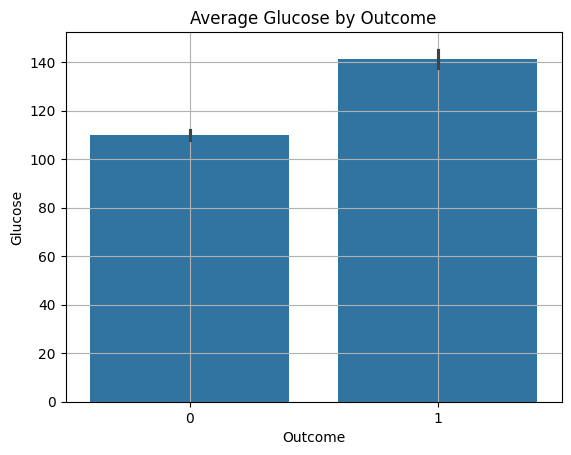

In [37]:
sns.barplot(x="Outcome", y="Glucose", data=data)
plt.xlabel("Outcome")
plt.ylabel("Glucose")
plt.title("Average Glucose by Outcome")
plt.grid(True)
plt.show()

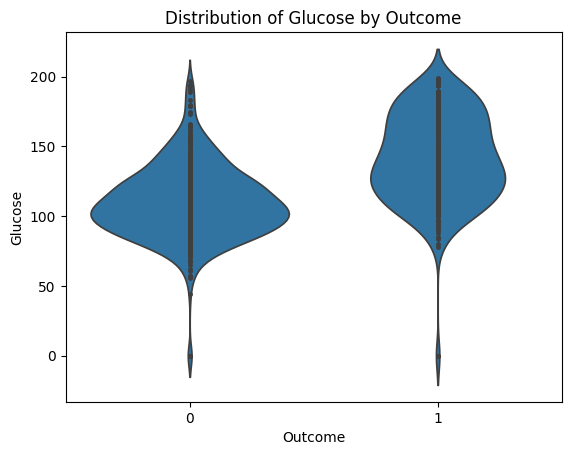

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot of Glucose distribution based on Outcome
sns.violinplot(x="Outcome", y="Glucose", data=df, inner="point")  # or inner="stick"

plt.xlabel("Outcome")
plt.ylabel("Glucose")
plt.title("Distribution of Glucose by Outcome")

plt.show()


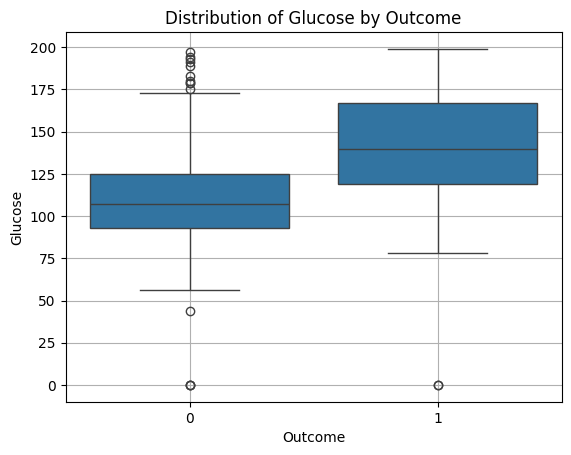

In [41]:
sns.boxplot(x="Outcome", y="Glucose", data=df)
plt.xlabel("Outcome")
plt.ylabel("Glucose")
plt.title("Distribution of Glucose by Outcome")
plt.grid(True)
plt.show()


<Axes: >

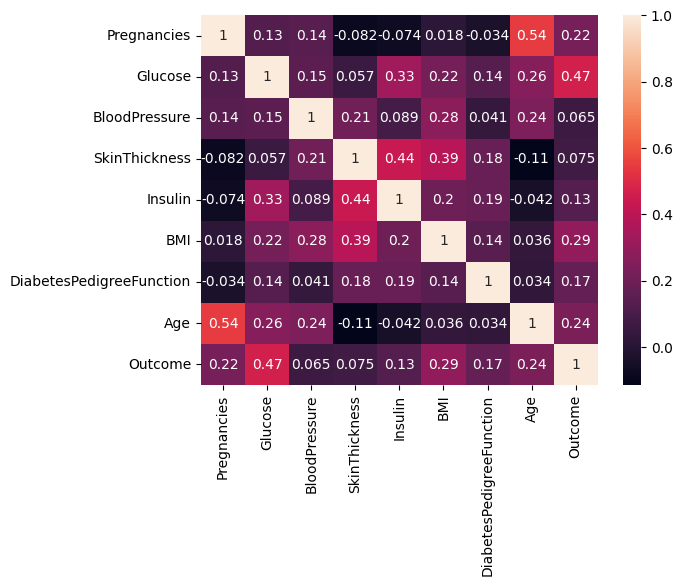

In [42]:
corr = df.corr()
#print(corr)
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    annot=True
)
